In [55]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import datetime as dt
import pandas_ta as ta

import warnings
warnings.filterwarnings('ignore')

import MetaTrader5 as mt5
from data_labeling import raw_returns_labeling
from helper_functions import split_dates, data_import_MT5, graphs_quantile_correlation

# Set configuration

In [56]:
kwargs = dict()

kwargs['n_jobs'] = 10

kwargs['symbol'] = 'SP500'
kwargs['time_frame'] = mt5.TIMEFRAME_D1

In [57]:
# Set direction

signal = 'shortonly'

if signal == 'longonly':
    kwargs['signal_direction'] = 'longonly'
    kwargs['type_bias'] = 'up'
else:
    kwargs['signal_direction'] = 'shortonly'
    kwargs['type_bias'] = 'down'

In [58]:
# Set config labeling

kwargs['bias_extraction'] = True
kwargs['shift'] = 10
kwargs['bias'] = 0.01

In [59]:
# Set config feature selection

kwargs['corr_target'] = 0.01
kwargs['method_corr'] = 'pearson'

# Split Data

In [60]:
kwargs['years_train_valid'] = 10
years_safe_date = 2

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=kwargs['years_train_valid'] * 365)
safe_start_date = start_date - dt.timedelta(days=years_safe_date * 365)
safe_start_date = dt.datetime.strftime(safe_start_date, "%Y-%m-%d")
start_date = dt.datetime.strftime(start_date, "%Y-%m-%d")
end_date = dt.datetime.strftime(end_date, "%Y-%m-%d")
oos_date = split_dates(start_date, end_date, 0.7)

kwargs['safe_start_date'] = safe_start_date
kwargs['start_date'] = start_date
kwargs['end_date'] = end_date
kwargs['oos_date'] = oos_date

# Load Data

In [61]:
success = False
count_pass = 0
while not success and count_pass < 2:
    count_pass += 1
    try:
        data_symbol = data_import_MT5(symbol=kwargs['symbol'], 
                                        start=kwargs['safe_start_date'],
                                        end=kwargs['end_date'],
                                        time_frame=kwargs['time_frame'])
        data_symbol.drop(data_symbol.columns[4], axis=1, inplace=True)
        success  = True
    except:
        mt5.shutdown()
        success = False
        print("Error when trying load data from metatrader. Try load data again")
        pass

if not success:
    print("Error. Can't load data from metatrader")
else:
    print("Data load successful!")

Data load successful!


In [62]:
data_symbol.head()

,open,high,low,close
date,,,,
2012-09-27,1435.1,1450.1,1435.1,1448.1
2012-09-28,1448.4,1449.1,1434.9,1440.1
2012-09-30,1438.6,1439.6,1434.6,1436.1
2012-10-01,1436.4,1457.1,1433.6,1442.9
2012-10-02,1442.6,1451.6,1438.1,1445.4


# Labeling Data



In [63]:
data_symbol = raw_returns_labeling(data_ohlc=data_symbol, **kwargs)

label_counts = data_symbol['LABEL'].value_counts()

data_label = data_symbol['LABEL']
        
data_label = data_label[data_label.index > kwargs['start_date']]

print(f'Label {label_counts.index[0]} = {label_counts.iloc[0]}')
print(f'Label {label_counts.index[1]} = {label_counts.iloc[1]}')

Label UP = 2414
Label DOWN = 710


# Create Features

In [64]:
data_features = pd.DataFrame(index=data_symbol.index)

open_ = data_symbol.open.shift(1)
high = data_symbol.high.shift(1)
low = data_symbol.low.shift(1)
close = data_symbol.close.shift(1)

data_features['atr_14'] = ta.atr(high, low, close, 14)
data_features['atr_28'] = ta.atr(high, low, close, 28)
data_features['atr_50'] = ta.atr(high, low, close, 50)

data_features['cma_7'] = close / ta.sma(close, 7)
data_features['cma_14'] = close / ta.sma(close, 14)
data_features['cma_21'] = close / ta.sma(close, 21)
data_features['cma_28'] = close / ta.sma(close, 28)
data_features['cma_50'] = close / ta.sma(close, 50)
data_features['cma_100'] = close / ta.sma(close, 100)
data_features['cma_200'] = close / ta.sma(close, 200)

data_features['ef_10'] = ta.er(close, 10)
data_features['ef_20'] = ta.er(close, 20)
data_features['ef_50'] = ta.er(close, 50)
data_features['ef_100'] = ta.er(close, 100)

data_features_label = pd.concat([data_symbol.iloc[:, :4], data_features, data_label], axis=1)
data_features_label.dropna(inplace=True)

data_features_label = data_features_label[data_features_label.index > kwargs['start_date']]

data_features_label.head()

,open,high,low,close,atr_14,atr_28,atr_50,cma_7,cma_14,cma_21,cma_28,cma_50,cma_100,cma_200,ef_10,ef_20,ef_50,ef_100,LABEL
date,,,,,,,,,,,,,,,,,,,
2014-09-29,1974.3,1976.8,1955.3,1968.3,18.438255,17.168278,16.725577,0.995816,0.993455,0.991435,0.991448,1.001251,1.011125,1.041611,0.067729,0.126386,0.008909,0.131240,DOWN
2014-09-30,1968.0,1977.8,1960.5,1961.3,18.656951,17.322983,16.821067,0.994888,0.990571,0.988530,0.988092,0.997571,1.007052,1.037379,0.120846,0.173679,0.007212,0.098444,DOWN
2014-10-01,1961.0,1966.5,1933.5,1941.3,18.560026,17.322162,16.830645,0.994200,0.988245,0.985939,0.985076,0.994131,1.003127,1.033288,0.307568,0.202914,0.025703,0.086945,DOWN
2014-10-02,1941.5,1945.3,1918.0,1938.0,19.591452,17.882085,17.154037,0.987149,0.980196,0.977265,0.975839,0.984388,0.992612,1.022433,0.428370,0.271863,0.092398,0.072059,DOWN
2014-10-03,1938.3,1964.0,1935.3,1959.8,20.142063,18.218439,17.356960,0.987660,0.980156,0.977021,0.975166,0.983124,0.990562,1.020401,0.482270,0.287929,0.095571,0.093330,DOWN


In [65]:
X = data_features_label.iloc[:, 4:-1]
y = data_features_label.iloc[:, -1]

In [66]:
# Scale data

X_norm = (X - X.min()) / \
(X.max() - X.min())

X_norm = X_norm.replace([np.inf, -np.inf], 0)
X_norm.fillna(0, inplace=True)

X_norm

,atr_14,atr_28,atr_50,cma_7,cma_14,cma_21,cma_28,cma_50,cma_100,cma_200,ef_10,ef_20,ef_50,ef_100
date,,,,,,,,,,,,,,
2014-09-29,0.047559,0.040280,0.034432,0.580744,0.625239,0.605823,0.660343,0.691865,0.692870,0.708314,0.067729,0.152888,0.015172,0.242632
2014-09-30,0.048863,0.041575,0.035527,0.576721,0.614267,0.597011,0.650672,0.682802,0.683404,0.698612,0.120846,0.210097,0.012240,0.181920
2014-10-01,0.048285,0.041568,0.035637,0.573740,0.605420,0.589150,0.641983,0.674329,0.674283,0.689232,0.307568,0.245463,0.044181,0.160633
2014-10-02,0.054437,0.046255,0.039347,0.543192,0.574799,0.562837,0.615372,0.650330,0.649847,0.664344,0.428370,0.328871,0.159390,0.133076
2014-10-03,0.057721,0.049071,0.041675,0.545403,0.574647,0.562096,0.613433,0.647215,0.645085,0.659687,0.482270,0.348305,0.164872,0.172452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-17,0.406374,0.538543,0.659033,0.675299,0.704652,0.664938,0.735598,0.742702,0.755166,0.804069,0.029326,0.047317,0.041203,0.275524
2024-09-18,0.398451,0.533553,0.656470,0.651649,0.706171,0.667696,0.733226,0.745240,0.755380,0.804574,0.295334,0.063828,0.042900,0.335805
2024-09-19,0.398890,0.534212,0.658157,0.627921,0.699062,0.662349,0.723402,0.741591,0.749179,0.798515,0.298938,0.019876,0.000816,0.331304


# Clusterize

In [67]:
method_cluster = 'kmeans'

k_cluster = 2

if method_cluster == 'kmeans':
    kmeans = KMeans(n_clusters=k_cluster, 
                    init='k-means++', 
                    n_init='auto', 
                    max_iter=300, 
                    tol=0.0001,  
                    random_state=42).fit(X_norm)
    cluster_labels = kmeans.labels_
if method_cluster == 'MiniBatchKMeans':
    kmeans = MiniBatchKMeans(
        init="k-means++",
        n_clusters=k_cluster,
        n_init=10,
        batch_size=512,
        max_no_improvement=10,
        verbose=0,
        random_state=42).fit(X_norm)
    cluster_labels = kmeans.labels_
if method_cluster == 'gmm':
    gmm = GaussianMixture(n_components=k_cluster, random_state=42)
    gmm.fit(X_norm)
    cluster_labels = gmm.predict(X_norm)

X["cluster_label"] = cluster_labels  

In [68]:
X

,atr_14,atr_28,atr_50,cma_7,cma_14,cma_21,cma_28,cma_50,cma_100,cma_200,ef_10,ef_20,ef_50,ef_100,cluster_label
date,,,,,,,,,,,,,,,
2014-09-29,18.438255,17.168278,16.725577,0.995816,0.993455,0.991435,0.991448,1.001251,1.011125,1.041611,0.067729,0.126386,0.008909,0.131240,0
2014-09-30,18.656951,17.322983,16.821067,0.994888,0.990571,0.988530,0.988092,0.997571,1.007052,1.037379,0.120846,0.173679,0.007212,0.098444,0
2014-10-01,18.560026,17.322162,16.830645,0.994200,0.988245,0.985939,0.985076,0.994131,1.003127,1.033288,0.307568,0.202914,0.025703,0.086945,0
2014-10-02,19.591452,17.882085,17.154037,0.987149,0.980196,0.977265,0.975839,0.984388,0.992612,1.022433,0.428370,0.271863,0.092398,0.072059,0
2014-10-03,20.142063,18.218439,17.356960,0.987660,0.980156,0.977021,0.975166,0.983124,0.990562,1.020401,0.482270,0.287929,0.095571,0.093330,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-17,78.597173,76.691202,71.171375,1.017638,1.014330,1.010921,1.017569,1.021890,1.037932,1.083376,0.029326,0.039115,0.023978,0.149008,1
2024-09-18,77.268803,76.095087,70.947948,1.012180,1.014729,1.011830,1.016746,1.022920,1.038025,1.083596,0.295334,0.052764,0.024961,0.181572,1
2024-09-19,77.342460,76.173834,71.094989,1.006704,1.012861,1.010068,1.013336,1.021439,1.035356,1.080954,0.298938,0.016431,0.000598,0.179140,1


In [69]:
cluster_features = X.groupby(["cluster_label"]).mean().T
cluster_features

cluster_label,0,1
atr_14,32.485109,80.387185
atr_28,32.911104,78.028337
atr_50,33.390813,75.162639
cma_7,1.001524,1.000560
cma_14,1.003771,0.999863
cma_21,1.006199,0.998655
cma_28,1.008580,0.997578
cma_50,1.015424,0.995700
cma_100,1.029471,0.995478
cma_200,1.055190,1.001813


In [70]:
X.iloc[:, :-1].mean()

atr_14     45.361811
atr_28     45.039204
atr_50     44.619625
cma_7       1.001265
cma_14      1.002720
cma_21      1.004171
cma_28      1.005622
cma_50      1.010122
cma_100     1.020333
cma_200     1.040842
ef_10       0.338872
ef_20       0.247367
ef_50       0.158530
ef_100      0.115267
dtype: float64

In [71]:
cluster_features[2] = X.iloc[:, :-1].mean()
cluster_features

cluster_label,0,1,2
atr_14,32.485109,80.387185,45.361811
atr_28,32.911104,78.028337,45.039204
atr_50,33.390813,75.162639,44.619625
cma_7,1.001524,1.000560,1.001265
cma_14,1.003771,0.999863,1.002720
cma_21,1.006199,0.998655,1.004171
cma_28,1.008580,0.997578,1.005622
cma_50,1.015424,0.995700,1.010122
cma_100,1.029471,0.995478,1.020333
cma_200,1.055190,1.001813,1.040842


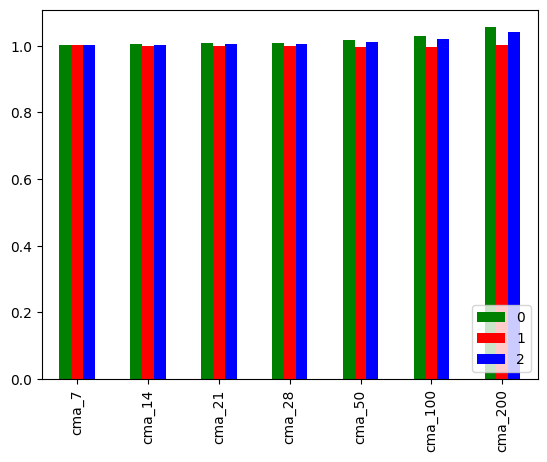

In [72]:
colors = ['green', 'red', 'blue']

items = ['cma_7', 'cma_14', 'cma_21', 'cma_28',
         'cma_50', 'cma_100', 'cma_200']

cluster_features.filter(
    items=items, axis=0
    ).plot(kind='bar', color=colors)
plt.legend(loc=4)
plt.show()

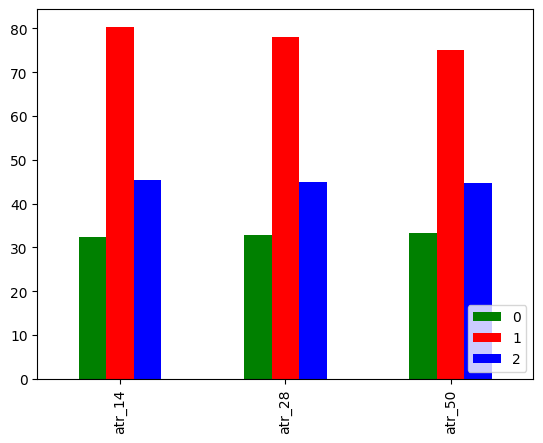

In [73]:
items = [ 'atr_14', 'atr_28', 'atr_50']

cluster_features.filter(
    items=items, axis=0
    ).plot(kind='bar', color=colors)
plt.legend(loc=4)
plt.show()

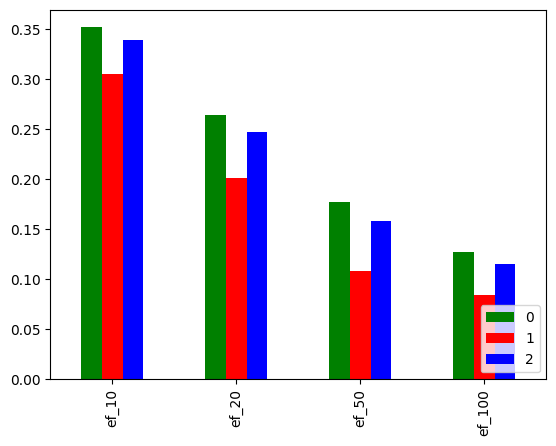

In [74]:
items = ['ef_10', 'ef_20', 'ef_50', 'ef_100']

cluster_features.filter(
    items=items, axis=0
    ).plot(kind='bar', color=colors)
plt.legend(loc=4)
plt.show()

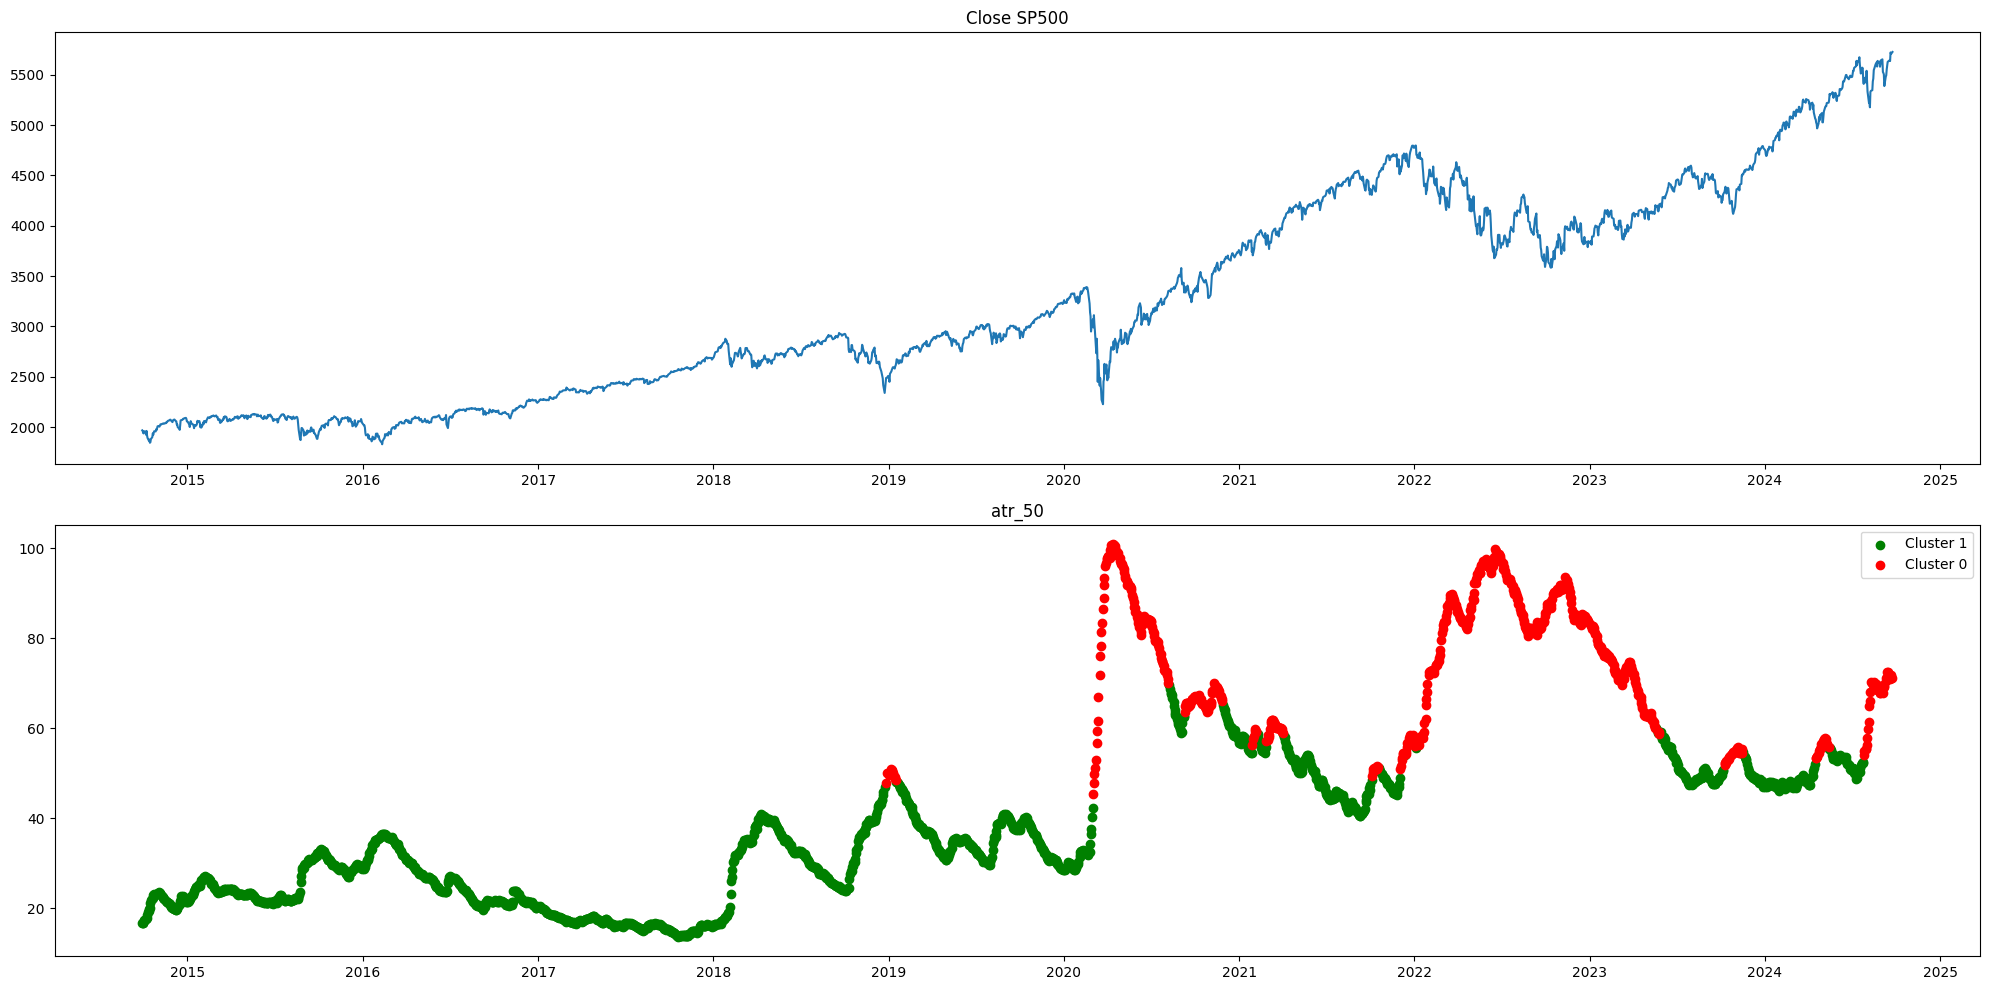

In [76]:
name_feature = 'atr_50'

cluster_0 = X[X["cluster_label"]==0][name_feature]
cluster_1 = X[X["cluster_label"]==1][name_feature]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
    
ax1.plot(data_features_label.index, data_features_label["close"])
ax1.set_title(f'Close {kwargs["symbol"]}')
    
scatter0 = ax2.scatter(cluster_0.index, cluster_0, c = "green", label='Cluster 1')
scatter1 = ax2.scatter(cluster_1.index, cluster_1, c = "red", label='Cluster 0')

ax2.set_title(f'{name_feature}')

if any([scatter0, scatter1]):
    ax2.legend()
plt.tight_layout()
plt.show()

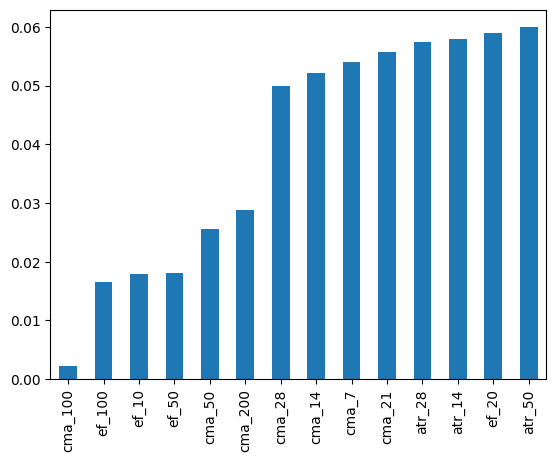

In [77]:
# Features corr with label

y_conv = y.replace('UP', 1).replace('DOWN', 0) \
    if signal == 'longonly' \
        else y.replace('UP', 0).replace('DOWN', 1)
        
data_corr = X.iloc[:, :-1].corrwith(y_conv, method=kwargs['method_corr']).abs()
data_corr.sort_values(ascending=True).plot(kind='bar')
plt.show()

In [78]:
kwargs['threshold_corr'] = 0.01

In [79]:
data_corr = data_corr[data_corr >= kwargs['threshold_corr']]
data_corr

atr_14     0.057984
atr_28     0.057433
atr_50     0.059943
cma_7      0.054021
cma_14     0.052118
cma_21     0.055737
cma_28     0.049940
cma_50     0.025616
cma_200    0.028860
ef_10      0.017892
ef_20      0.058881
ef_50      0.017998
ef_100     0.016584
dtype: float64

In [90]:
import os
import sys
sys.path.append("E:\\algorithmic_trading\\python\\AlgoQuantProject\\AlgoMLEngine")
os.environ['PYTHONPATH'] = "E:\\algorithmic_trading\\python\\AlgoQuantProject\\AlgoMLEngine"

In [91]:
# Generate rules
kwargs['range_models_pass'] = 2
kwargs['opt_run'] = 3
kwargs['opt_folds'] = 2

from generator_ripper.generator_rules import rules_extract_parallel            

rules_gen = rules_extract_parallel(X_train=X.loc[:, data_corr.index],
                                   y_train=y,
                                   range_models=kwargs['range_models_pass'],
                                   opt_run=kwargs['opt_run'],
                                   opt_folds=kwargs['opt_folds'],
                                   n_cpus=kwargs['n_jobs'])

In [89]:
rules_gen[['rules']].head(20)

,rules
0,(ef_100 <= 0.062867) & (cma_200 <= 1.001048) &...
1,(atr_14 >= 38.780957) & (atr_14 <= 41.787358) ...
2,(ef_100 <= 0.134187) & (atr_14 >= 58.203042) &...
3,(ef_20 <= 0.175569) & (ef_100 >= 0.211237) & (...
4,(cma_200 <= 1.016235) & (ef_100 <= 0.063168) &...
5,(atr_50 <= 86.476006) & (ef_50 <= 0.121604) & ...
6,(cma_21 <= 1.003153) & (atr_28 >= 29.540179) &...
7,(cma_28 <= 1.008219) & (atr_50 >= 41.353692) &...
8,(atr_14 >= 59.357123) & (atr_50 <= 88.631609) ...
9,(atr_28 >= 19.289646) & (atr_28 <= 22.520176) ...
